In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [65]:
image = cv2.imread('Finding/1.jpg')

In [66]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

binary = cv2.bitwise_not(gray)

_ ,thresh = cv2.threshold(gray ,250,255,cv2.THRESH_BINARY_INV)

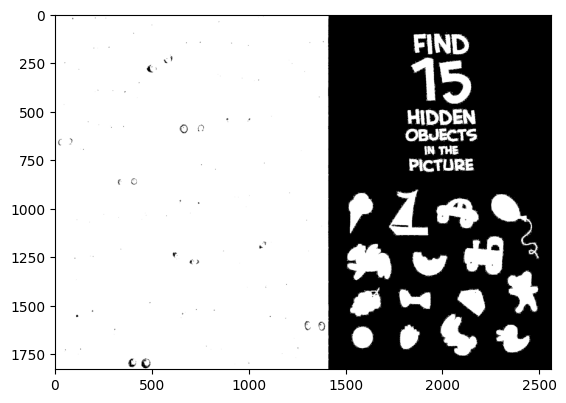

In [67]:
plt.imshow(thresh, cmap='grey')

In [68]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
kernel

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=uint8)

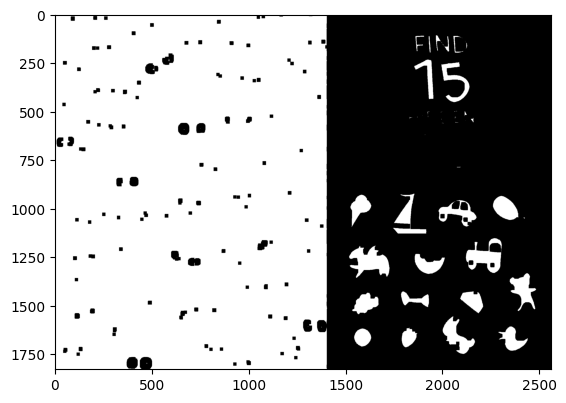

In [69]:
erosion = cv2.erode(thresh, kernel, iterations=4)
plt.imshow(erosion, cmap='gray')

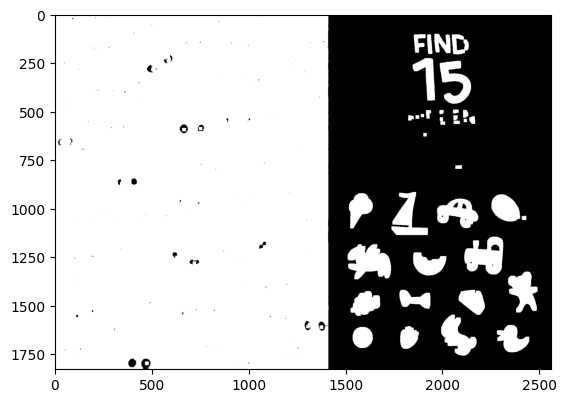

In [70]:
dilation = cv2.dilate(erosion, kernel, iterations=4)
plt.imshow(dilation, cmap='gray')

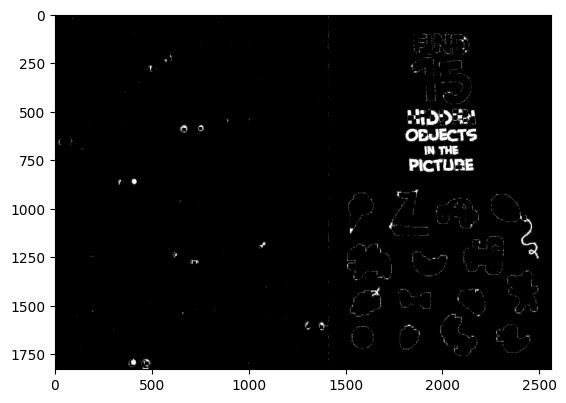

In [71]:
x = dilation - thresh
plt.imshow(x, cmap='gray')

In [72]:
def opening(image, iterations=5):
    img = image.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _ ,thresh = cv2.threshold(gray ,250,255,cv2.THRESH_BINARY_INV)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    erosion = cv2.erode(thresh, kernel, iterations=iterations)
    dilation = cv2.dilate(erosion, kernel, iterations=iterations)

    return dilation

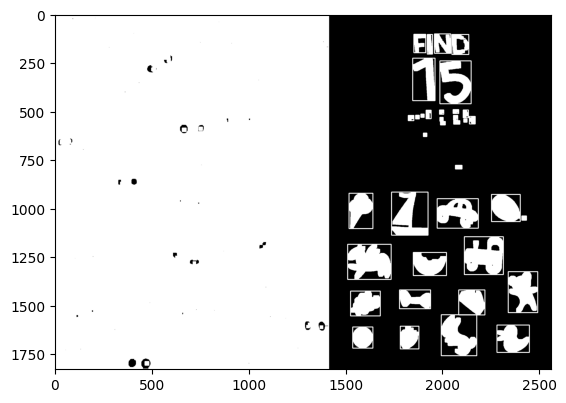

In [73]:
img = opening(image, 4)
contours,hierarchy = cv2.findContours(img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:    
    x,y,w,h = cv2.boundingRect(contour)
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),3)

plt.imshow(img, cmap='gray')

In [87]:
def get_all_object(image):
    img = image.copy()
    contours, _ = cv2.findContours(img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = []
    for contour in contours:    
        x,y,w,h = cv2.boundingRect(contour)
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),3)
        if max(w, h) >= 100:
            bounding_boxes.append((x,y,w,h))

    plt.imshow(img, cmap='gray')
    return bounding_boxes

[(1532, 1608, 106, 114),
 (2272, 1600, 174, 144),
 (1778, 1600, 102, 128),
 (1984, 1544, 192, 216),
 (2072, 1416, 144, 144),
 (1774, 1416, 162, 104),
 (1520, 1408, 160, 152),
 (2331, 1324, 158, 217),
 (1840, 1224, 183, 126),
 (1504, 1184, 228, 188),
 (2106, 1144, 204, 200),
 (1965, 950, 218, 154),
 (2247, 928, 244, 332),
 (1512, 921, 128, 210),
 (1720, 904, 203, 235),
 (1975, 677, 105, 50),
 (1806, 589, 271, 70),
 (1910, 494, 138, 80),
 (1979, 239, 165, 225),
 (1833, 224, 127, 224),
 (2040, 104, 94, 104),
 (1847, 101, 97, 107),
 (1952, 100, 88, 108),
 (0, 0, 1409, 1829)]

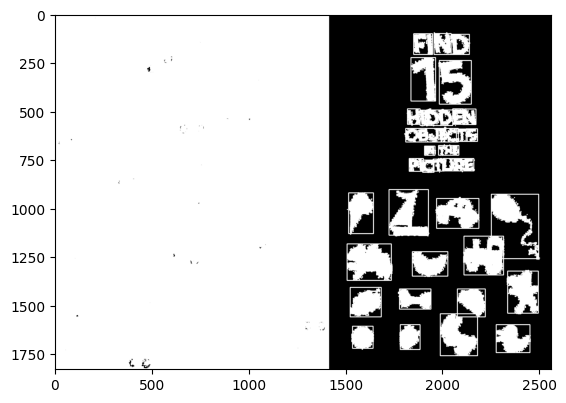

In [75]:
get_all_object(thresh)

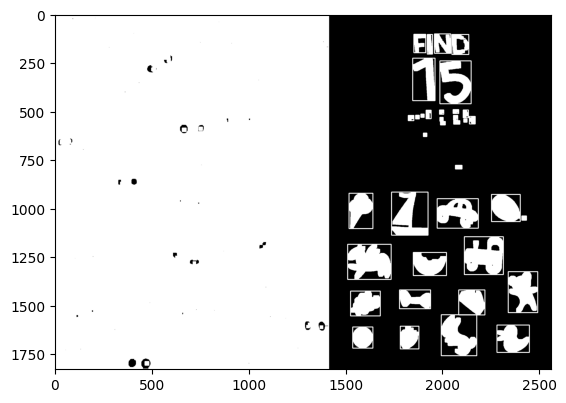

In [88]:
opened = opening(image, 4)
all_objects = get_all_object(opened)

In [77]:
def get_bounding_box_from_point(point):
    for object in all_objects:
        x, y, w, h = object
        u, v = point
        if u >= x and v >= y and u <= x + w and v <= y + h:
            return object
    return None

In [78]:
get_bounding_box_from_point((1800, 1700))

(1778, 1608, 96, 117)

In [79]:
def draw_bounding_box(image, point):
    # Get bounding box
    if len(image.shape) == 3:
        img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        img = image.copy()
    bbox = get_bounding_box_from_point(point)
    
    if bbox:
        # Draw the rectangle
        x, y, w, h = bbox
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 5)
        
        # Draw the point
        cv2.circle(img, (int(point[0]), int(point[1])), 3, (0, 0, 255), -1)
        
        # Display result
        # cv2.imshow('Result', image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        plt.imshow(img, cmap='grey')
        
        return bbox
    else:
        print("No object found at the given point")
        return None

(1778, 1608, 96, 117)

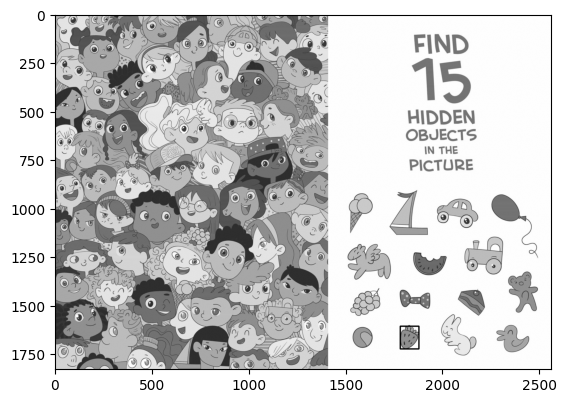

In [80]:
draw_bounding_box(image, (1800, 1700))

In [81]:
def extract_region(image, bbox):
    """
    Extract a region from an image using a bounding box
    
    Args:
        image: Input image (numpy array)
        bbox: Tuple of (x, y, width, height) or (x1, y1, x2, y2)
    
    Returns:
        cropped_image: The extracted region
    """
    x, y, w, h = bbox
    cropped = image[y:y+h, x:x+w]
    
    return cropped

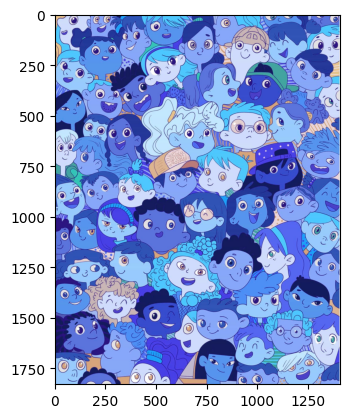

In [82]:
target = all_objects[-1]
plt.imshow(extract_region(image, target))

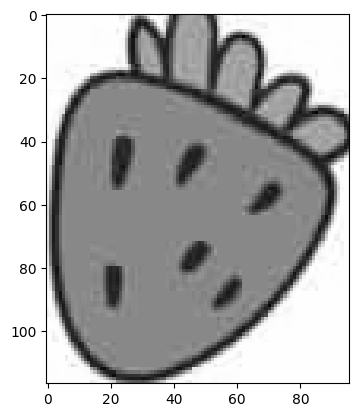

In [83]:
strawberry = get_bounding_box_from_point((1800, 1700))
strawberry_image = extract_region(image, strawberry)

strawberry_image = cv2.cvtColor(strawberry_image, cv2.COLOR_BGR2GRAY)
plt.imshow(strawberry_image, cmap='grey')

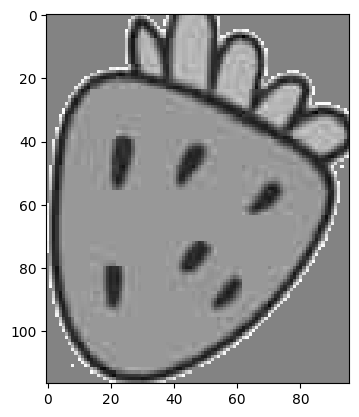

In [84]:
def closing(image, iterations=5):
    img = image.copy()
    img[img > 230] = 127
    return img
xd = closing(strawberry_image)
# xd = cv2.GaussianBlur(xd, (5,5), cv2.BORDER_DEFAULT)
plt.imshow(xd, cmap='gray')

In [85]:
def multi_scale_template_matching(image, points, scale_range=(0.2, 1.5), scale_steps=20, threshold=0.8):
    """
    Perform multi-scale template matching
    
    Args:
        image: Source image to search in
        template: Template image to search for
        scale_range: Tuple of (min_scale, max_scale)
        scale_steps: Number of scales to try
        threshold: Matching threshold (0-1)
    
    Returns:
        list of (x, y, scale, confidence) for matches above threshold
    """
    # Convert images to grayscale
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image.copy()

    # gray_image = cv2.GaussianBlur(gray_image,(3,3),cv2.BORDER_DEFAULT)
    
    template_bbox = get_bounding_box_from_point(points)
    gray_template = extract_region(gray_image, template_bbox)
    # gray_template = cv2.equalizeHist(gray_template)

    gray_image = extract_region(gray_image, all_objects[-1])
    # gray_image = cv2.equalizeHist(gray_image)

    mean = np.uint8(np.mean(gray_image))
    gray_template[gray_template > 250] = mean

    # gray_template = cv2.GaussianBlur(gray_template,(3,3),cv2.BORDER_DEFAULT)
    # gray_template = gray_template - mean
    # gray_image = gray_image - mean

    # Store best matches
    matches = []
    
    # Generate scales to try
    scales = np.linspace(scale_range[0], scale_range[1], scale_steps)
    
    # Try each scale
    for scale in scales:
        # Resize the image according to the scale
        resized_template = cv2.resize(gray_template, None,
                                    fx=scale, fy=scale,
                                    interpolation=cv2.INTER_AREA)
        
        # Get the current template size
        h, w = resized_template.shape
        
        # If resized template is larger than the image, skip this scale
        if h > gray_image.shape[0] or w > gray_image.shape[1]:
            continue
        
        # Apply template matching
        result = cv2.matchTemplate(gray_image, resized_template, cv2.TM_CCOEFF_NORMED)
        # plt.imshow(result, cmap='gray')
        # plt.savefig(f'plots/{scale}.png')

        # Find locations where matching exceeds the threshold
        locations = np.where(result >= threshold)
        
        for pt in zip(*locations[::-1]):  # Switch columns and rows
            match = {
                'x': int(pt[0]),
                'y': int(pt[1]),
                'scale': scale,
                'confidence': result[pt[1], pt[0]],
                'width': int(w),
                'height': int(h)
            }
            matches.append(match)
    
    # Apply non-maximum suppression to remove overlapping matches
    matches = non_max_suppression(matches)
    
    return matches

def non_max_suppression(matches, overlap_thresh=0.3):
    """
    Apply non-maximum suppression to remove overlapping matches
    """
    if not matches:
        return []
    
    # Convert matches to numpy array for easier processing
    boxes = np.array([[m['x'], m['y'], m['x'] + m['width'], m['y'] + m['height']] for m in matches])
    scores = np.array([m['confidence'] for m in matches])
    
    # Calculate areas
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    
    # Sort by confidence
    idxs = np.argsort(scores)[::-1]
    
    pick = []
    while len(idxs) > 0:
        i = idxs[0]
        pick.append(i)
        
        # Find overlapping boxes
        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])
        
        # Calculate overlap areas
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[idxs[1:]]
        
        # Delete overlapping boxes
        idxs = np.delete(idxs, np.concatenate(([0], np.where(overlap > overlap_thresh)[0] + 1)))
    
    return [matches[i] for i in pick]

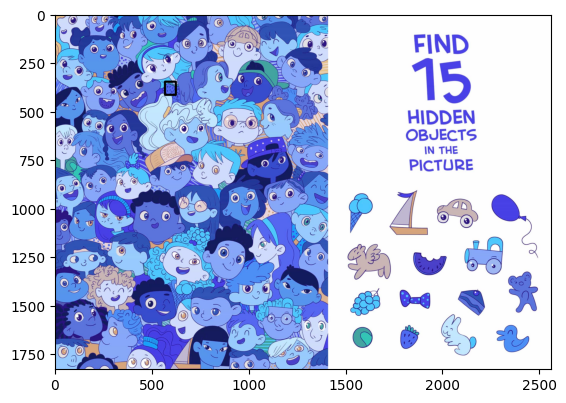

In [90]:
matches = multi_scale_template_matching(
        image,
        (1800, 1700),
        scale_range=(0.5, 1),  
        scale_steps=20,          # Number of different scales to try
        threshold=0.5         # Confidence threshold
    )

# for match in matches:
#     print(match['x'], match['y'], match['height'], match['width'], match['scale'], match['confidence'])
result_image = image.copy()
match = matches[0]
x = match['x']
y = match['y']
w = match['width']
h = match['height']

# Draw rectangle around match
cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 0, 0), 10)
    
plt.imshow(result_image, cmap='gray')
